Script to combine JSON simulation result files into a unified results structure.

Each input file must follow the naming convention:
    `{name}_sim{sim_id}_{timestamp}.json`

and contain a JSON object with keys:
- scenario_name: str
- sim_id: int
- agent_names: list of str
- cum_regrets: list of lists (one per agent)
- time_agents: list of lists (one per agent)

The script aggregates data across multiple files for the same scenario and sim_id,
producing a `results` dict:

```
results[scenario_name] = {
    "scenario_name": scenario_name,
    "sim_id": [list of sim_ids],
    "regrets": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
    "times": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
}
```

## Pre

In [1]:
import os
import glob
import json
import numpy as np

def load_and_combine(json_dir: str = '.'):
    # Temporary storage: scenario -> sim_id -> list of file data dicts
    files_data = {}

    # Collect and parse all JSON files
    for filepath in glob.glob(os.path.join(json_dir, '*.json')):
        with open(filepath, 'r') as f:
            data = json.load(f)
        scenario = data['scenario_name']
        sim_id = data['sim_id']
        # filter out 'Random' agent except for the first time
        rnd_idx = data['agent_names'].index('Random') if 'Random' in data['agent_names'] else None
        if rnd_idx is not None:
            # if this sim_id already has a 'Random' agent, remove it
            for existing_entry in files_data.get(scenario, {}).get(sim_id, []):
                if 'Random' in existing_entry['agent_names']:
                    data['agent_names'].pop(rnd_idx)
                    data['cum_regrets'] = np.delete(data['cum_regrets'], rnd_idx, axis=1).tolist()
                    data['time_agents'] = np.delete(data['time_agents'], rnd_idx, axis=1).tolist()
                    break
        files_data.setdefault(scenario, {}).setdefault(sim_id, []).append({
            'agent_names': data['agent_names'],
            'cum_regrets': data['cum_regrets'],
            'time_agents': data['time_agents'],
        })

    results = {}
    # Combine per scenario
    for scenario_name, sim_dict in files_data.items():
        # Determine all unique agent names
        all_agents = sorted({name for entries in sim_dict.values() for e in entries for name in e['agent_names']})

        # Simulation IDs sorted
        sim_ids = sorted(sim_dict.keys())
        n_simulations = max(sim_ids) + 1
        # Determine number of draws from the first entry
        sample = sim_dict[sim_ids[0]][0]
        n_draws = len(sample['cum_regrets'])

        # Allocate arrays for each agent
        all_regrets = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}
        all_times   = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}

        # Fill arrays with transposed data (draws × agents -> agents × draws)
        for sim_id, entries in sim_dict.items():
            for entry in entries:
                cum_regs = np.array(entry['cum_regrets'])   # shape: (n_draws, n_agents)
                time_ag  = np.array(entry['time_agents'])   # shape: (n_draws, n_agents)
                for i, name in enumerate(entry['agent_names']):
                    all_regrets[name][sim_id, :] = cum_regs[:, i]
                    all_times[name][sim_id, :]   = time_ag[:, i]

        # Build scenario's combined results
        results[scenario_name] = {
            'scenario_name': scenario_name,
            'sim_id': sim_ids,
            'regrets': all_regrets,
            'times': all_times,
        }

    return results

In [2]:
combined = load_and_combine('./results/compare_all')

In [3]:
from compare_agents import *

# print_summary_results(combined)

In [4]:
combined = {k: combined[k] for k in [
    # "Linear",
    # "Friedman",
    # "LinFriedman",
    # "Friedman2",
    # "Friedman3",
    "Magic",
    "Shuttle",
    "Adult",
    "Mushroom",
    # "Iris",
    # "Wine",
    # "Heart"
    ] if k in combined}

## Printed Info

In [12]:
print_topn_agents_per_scenario(combined, 5)


Top 5 agents per scenario:
                Magic        Shuttle                 Adult       Mushroom
Rank 1      XGBoostTS      XGBoostTS             XGBoostTS   BARTm_tree2x
Rank 2           RFTS           RFTS                  RFTS           RFTS
Rank 3          BARTo  LogisticBARTm  LogisticBARTm_tree2x          BARTm
Rank 4   BARTo_tree2x          BARTm         LogisticBARTm      XGBoostTS
Rank 5  LogisticBARTo   BARTm_tree2x          BARTm_tree2x  LogisticBARTm


In [6]:
print_pairwise_win_tie_lose(combined)


Totals across all scenarios (sorted by win*3+tie):
                      win  tie  lose
XGBoostTS              37   17     1
RFTS                   23   31     1
BARTm                  14   37     4
BARTm_tree2x           14   37     4
LogisticBARTm          12   35     8
LogisticBARTm_tree2x   11   35     9
BARTo                   6   42     7
BARTo_tree2x            6   39    10
LogisticBARTo           6   39    10
LogisticBARTo_tree2x    5   41     9
LinearTS                4   20    31
Random                  0   11    44


In [7]:
print_relative_performance(combined)


Agent performance (relative to LinearTS):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
XGBoostTS                    0.220    0.184    0.368
RFTS                         0.281    0.170    0.339
BARTm_tree2x                 0.297    0.182    0.363
BARTm                        0.327    0.178    0.357
LogisticBARTm                0.423    0.157    0.314
LogisticBARTm_tree2x         0.474    0.144    0.287
BARTo_tree2x                 0.592    0.132    0.263
BARTo                        0.619    0.110    0.220
LogisticBARTo                0.622    0.118    0.236
LogisticBARTo_tree2x         0.904    0.076    0.151
LinearTS                     1.000    0.000    0.000
Random                       3.547    1.290    2.579


In [8]:
print_relative_performance(combined, "times")


Agent performance (relative to LinearTS):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
Random                       0.206    0.013    0.026
LinearTS                     2.161    0.090    0.180
BARTo                      120.570   39.562   79.123
XGBoostTS                  133.483    6.687   13.373
BARTm                      157.538  143.528  287.055
RFTS                       181.342   37.666   75.332
BARTo_tree2x               206.794   24.918   49.835
LogisticBARTo              232.071   15.146   30.293
BARTm_tree2x               261.436  104.031  208.062
LogisticBARTm              268.068   27.341   54.681
LogisticBARTo_tree2x       444.739   29.720   59.441
LogisticBARTm_tree2x       512.119   52.926  105.851


## Plot & Print

In [9]:
plot_print_total_regret_factors(combined)


Mean relative regret by "Model" category (rows) and scenario (columns):
          Logistic m  Logistic o        m        o
Adult       1678.875    1846.250 1702.625 1847.250
Average        0.005       0.006    0.005    0.005
Magic       1769.875    1757.812 1827.938 1717.188
Mushroom     130.625     318.688   68.812  218.875
Shuttle      602.500    1260.562  557.562  788.188

Mean relative regret by "Tree" category (rows) and scenario (columns):
               1x       2x
Adult    1747.000 1790.500
Average     0.005    0.005
Magic    1757.375 1779.031
Mushroom  158.969  209.531
Shuttle   714.031  890.375

Mean relative regret by "Iter" category (rows) and scenario (columns):
Empty DataFrame
Columns: []
Index: []

Mean relative regret by "MC" category (rows) and scenario (columns):
Empty DataFrame
Columns: []
Index: []


## "Beautiful" Plots

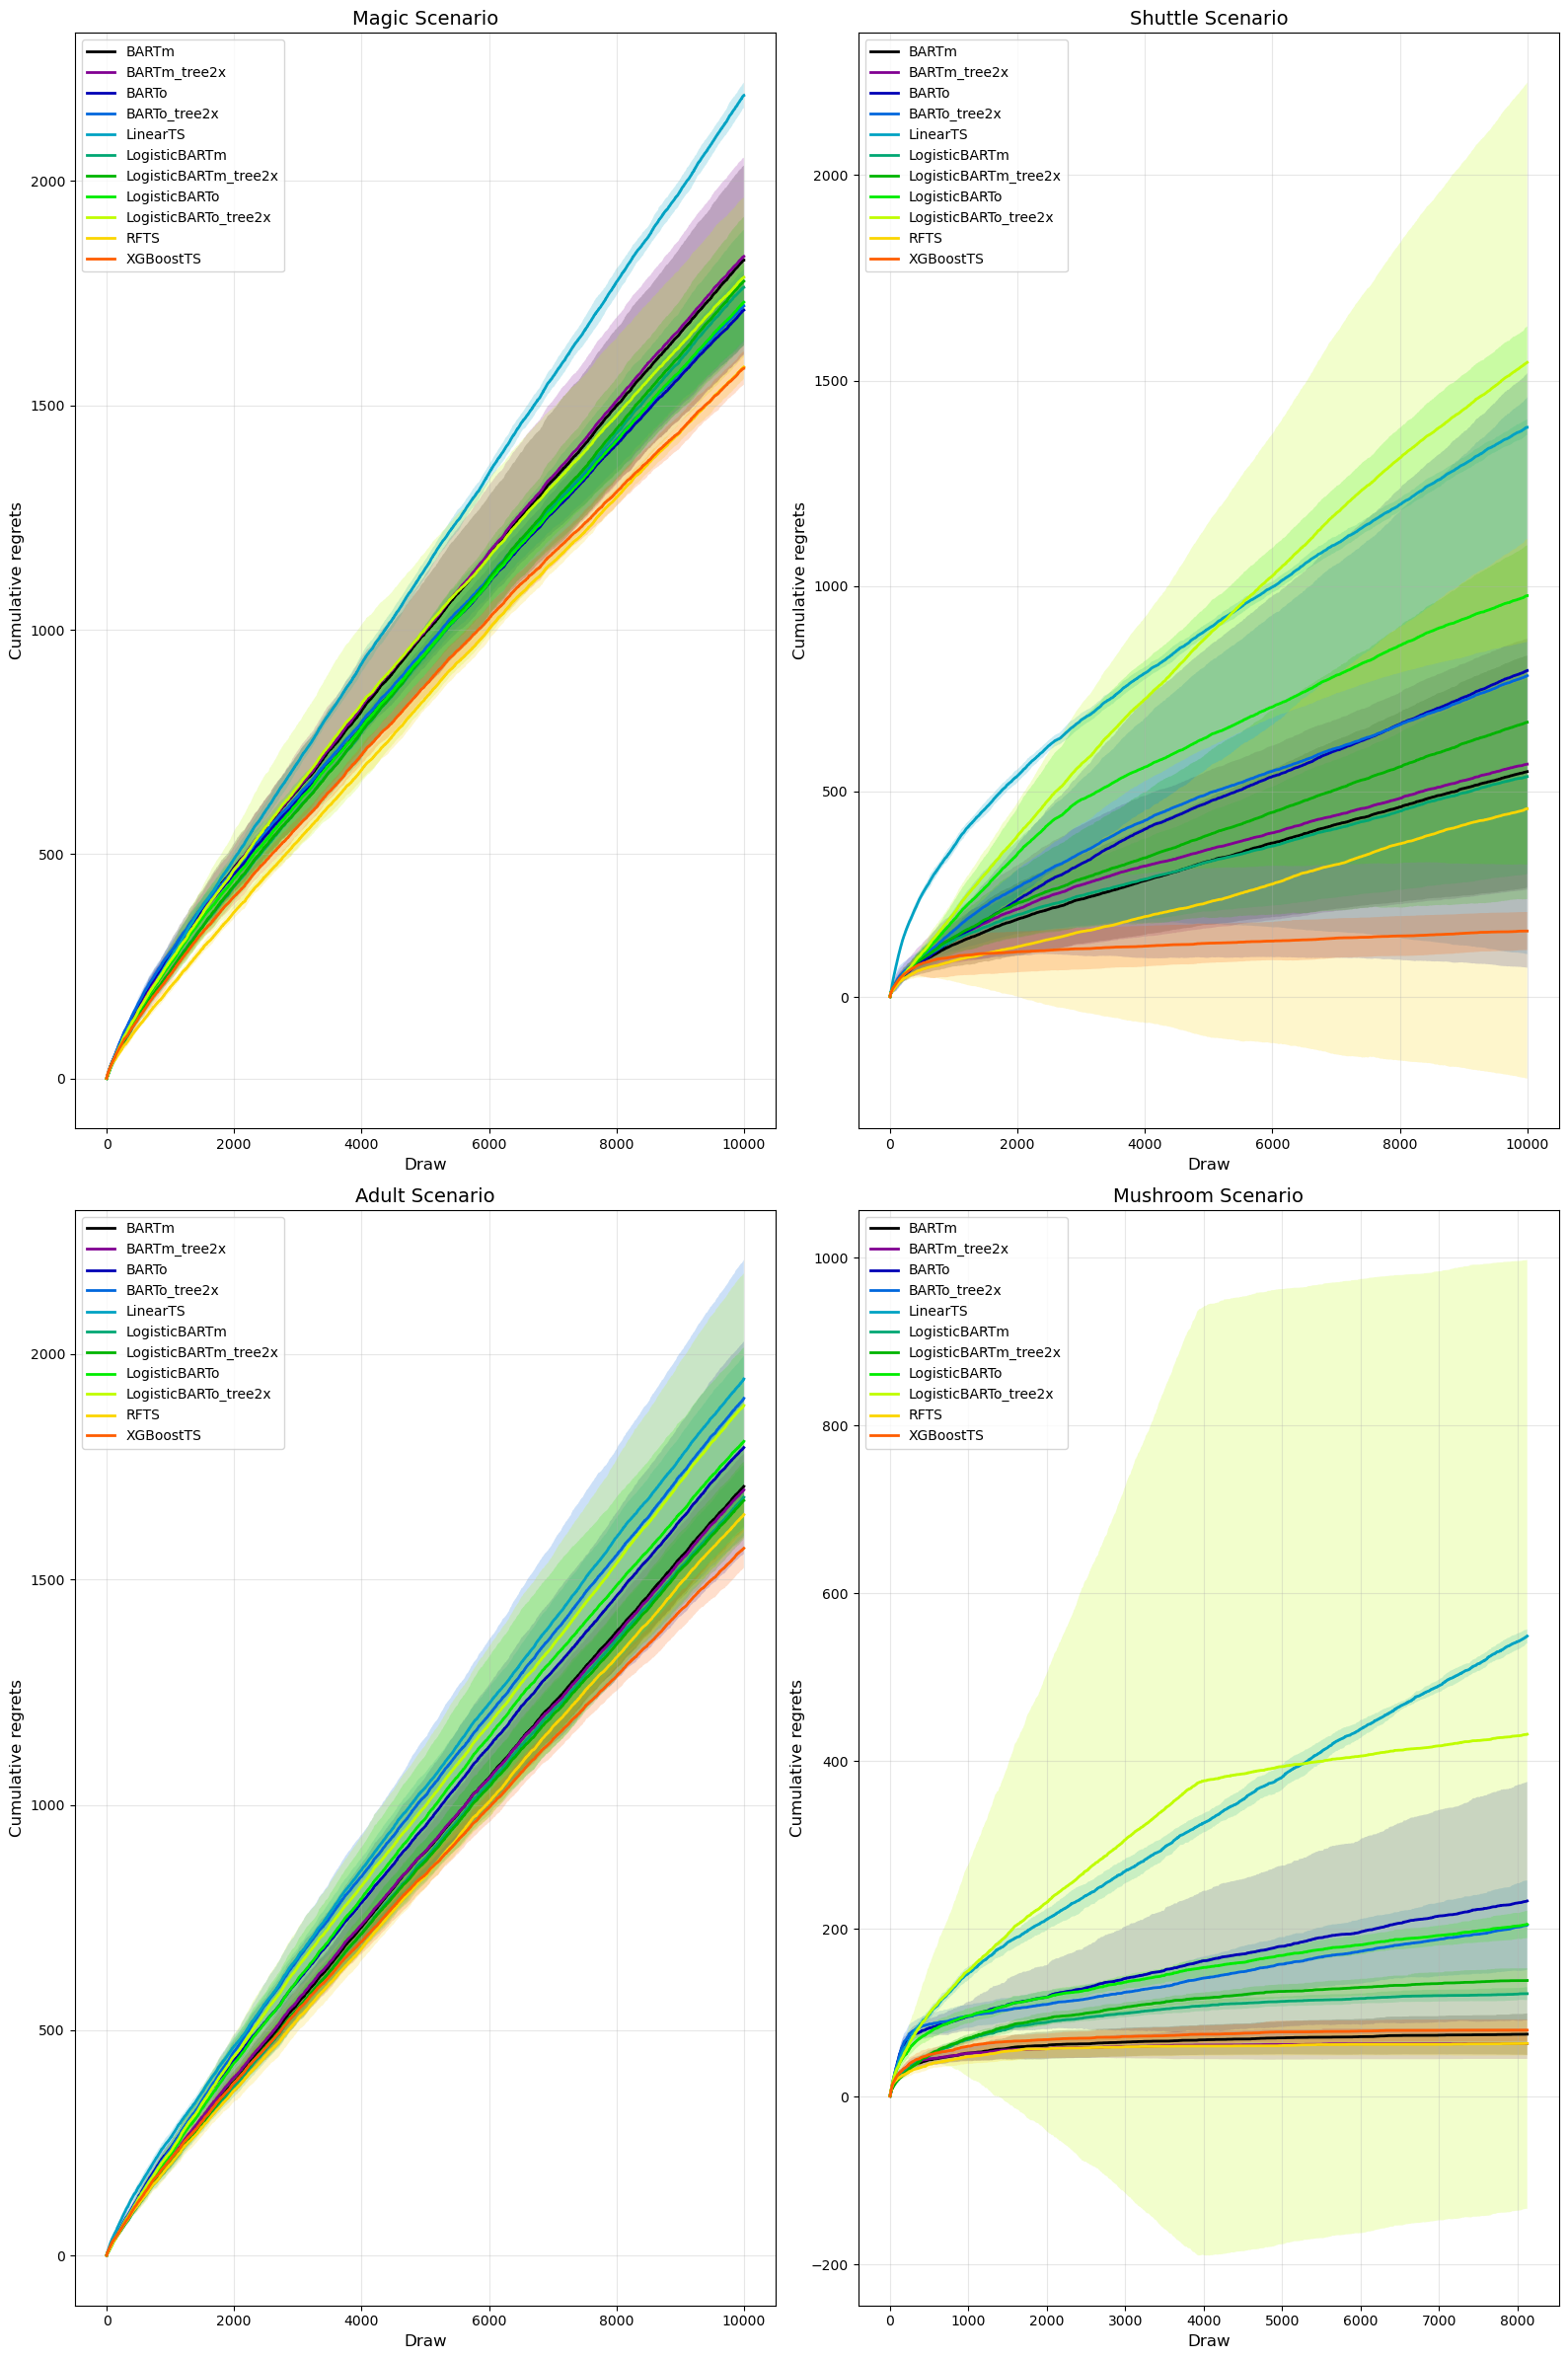

In [10]:
plot_comparison_results(combined, show_random=False)

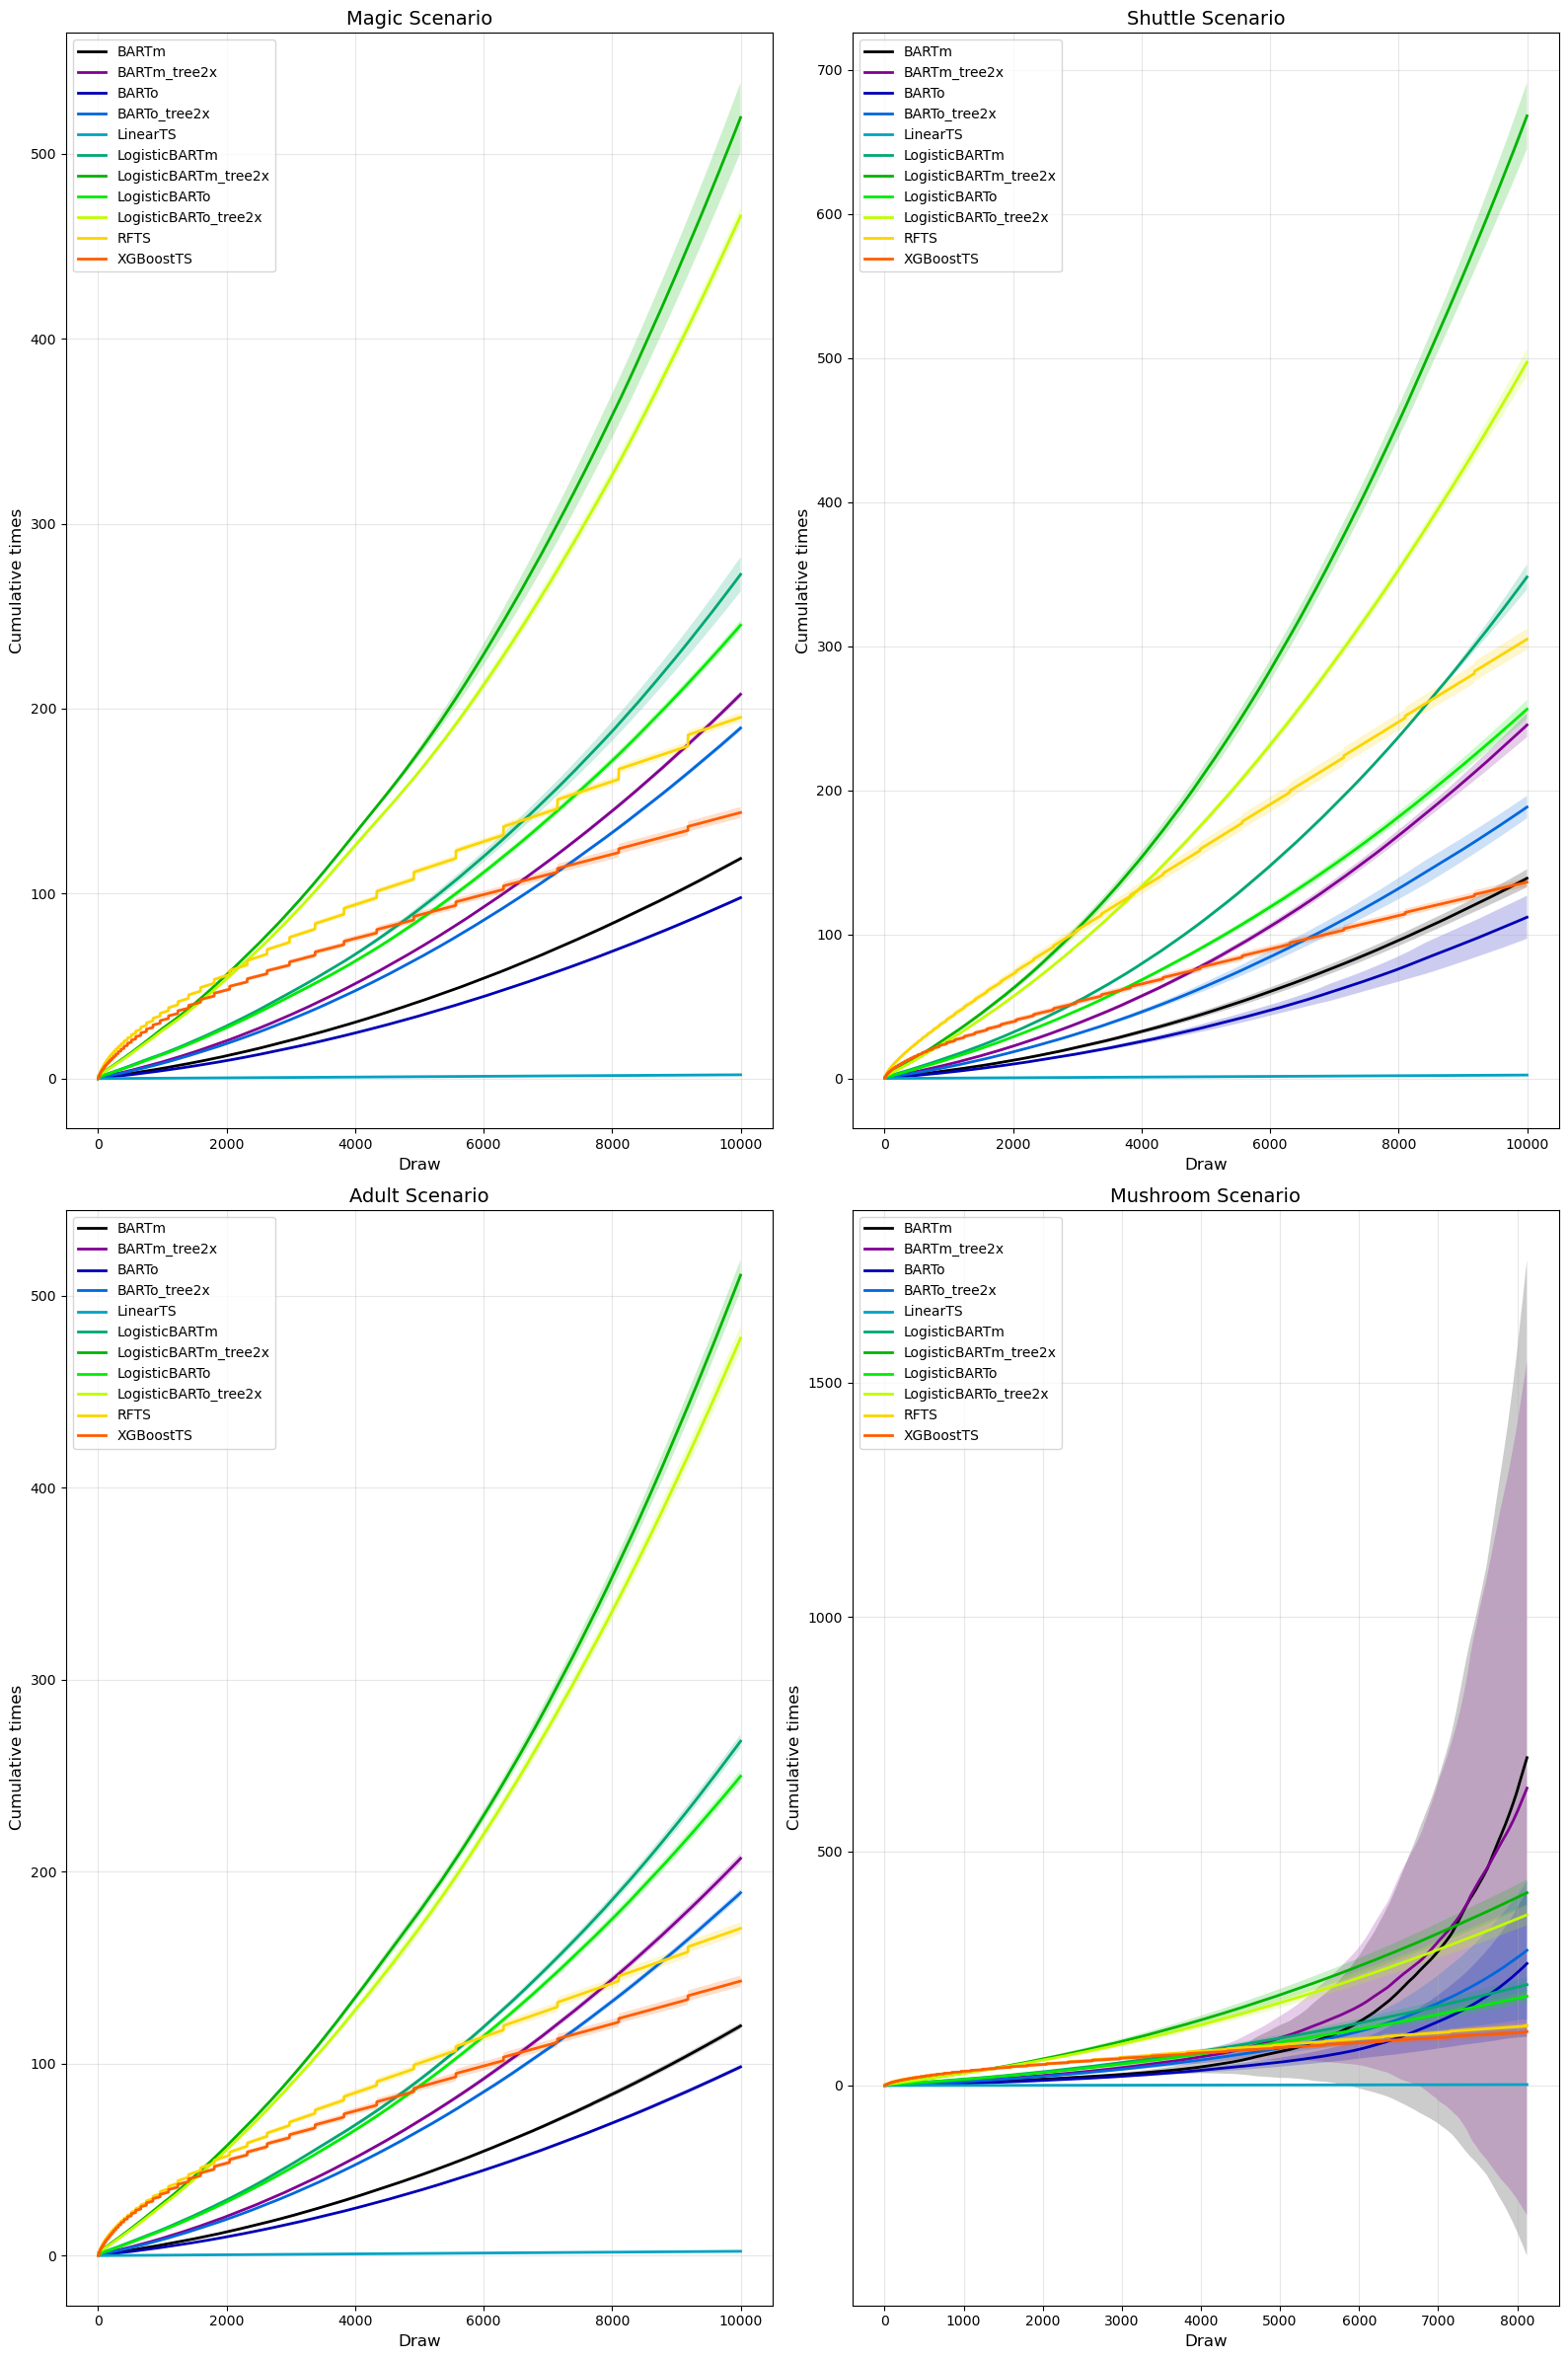

In [11]:
plot_comparison_results(combined, show_random=False, target="times")